Embeddings Quality Experiment

This notebook evaluates the quality of embeddings before clustering.
The idea is to understand how robust are the embeddings in representing media in a classification task.

This notebook is divided into X Sections
Section 1:
    
    Using the embeddings for classification task Relevant/Irrelevant Classification)

## Embeddings classification experiments

In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
# insert labels into the extracted embeddings
data_embeddings = pd.read_pickle('../data/tweet_data_all_emb.pkl')

for t_data in ['train','eval','test_data']:
    
    # Read labeled data
    labeled_data = pd.read_pickle(f'../data/{t_data}.pkl').drop(columns=['orig_path','work_time','text'])
    labeled_data = labeled_data.rename(columns={'txt': 'text_label'})
    
    # Label for both modalities
    for index, row in labeled_data.iterrows():
        labeled_data.loc[index, 'post_label'] = True if (row['img_label'] or row['text_label']) else False
        
    
    # merge labeled data with embeddings
    labeled_data = labeled_data.merge(data_embeddings, on='tweet_id')
    
    # dump result
    labeled_data.to_pickle(f'{t_data}_emb_qualy_exp.pkl')

In [ ]:
labeled_data

In [3]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from tqdm.notebook import tqdm
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix

In [9]:
def get_trainning_data(embedding_name, label='post_label'):
    
    train_data = pd.read_pickle('train_emb_qualy_exp.pkl')
    trainX = np.array(train_data[embedding_name].iloc[0])
    trainY = np.array(train_data[label].iloc[0])
    
    for index, row in train_data.iterrows():
        if index == 0:
            continue
        trainX = np.vstack([trainX, row[embedding_name]])
        trainY = np.vstack([trainY, row[label]])
        
    
    eval_data = pd.read_pickle('eval_emb_qualy_exp.pkl')

    for index, row in eval_data.iterrows():
        trainX = np.vstack([trainX, row[embedding_name]])
        trainY = np.vstack([trainY, row[label]])
    
    return trainX, trainY.ravel()

def get_test_data(embedding_name, label='post_label'):
    
    test_data = pd.read_pickle('test_data_emb_qualy_exp.pkl')
    testX = np.array(test_data[embedding_name].iloc[0])
    testY = np.array(test_data[label].iloc[0])
    
    for index, row in test_data.iterrows():
        if index == 0:
            continue
        testX = np.vstack([testX, row[embedding_name]])
        testY = np.vstack([testY, row[label]])
           
    return testX, testY.ravel()


def check_embed_quality(embedding_name, label='post_label'):
    
    
    trainX, trainY =  get_trainning_data(embedding_name, label)
    testX, testY =  get_test_data(embedding_name, label)
    
    test_score = []
    train_score = []
    for i in tqdm(range(10), leave=True):
        clf = MLPClassifier(hidden_layer_sizes=(128, 128, 64), max_iter=300, early_stopping=True).fit(trainX, trainY)
        #clf = MLPClassifier(max_iter=300, early_stopping=True).fit(trainX, trainY)
        #clf = SVC(gamma=2, C=1).fit(trainX, trainY)

        train_score.append(balanced_accuracy_score(trainY, clf.predict(trainX)))

        test_score.append(balanced_accuracy_score(testY, clf.predict(testX)))
    
    test_conf_matrix = confusion_matrix(testY, clf.predict(testX))
    
    return train_score, test_score, test_conf_matrix

In [12]:
experiment_result = {}
pbar = tqdm(['Roberta_embeddings', 'MobileNet_embeddings', 'clip_imgs_embeddings',
                   'clip_text_embeddings', 'MobileNet_Roberta_embeddings',
                   'clip_imgs_cat_text_embeddings', 'clip_imgs_sum_text_embeddings'])

for embedding in pbar:
    pbar.set_description(embedding)
    experiment_result[embedding] = {}
    for label in ['post_label', 'img_label', 'text_label']:
        res = check_embed_quality(embedding, label)
        experiment_result[embedding][label] = {}
        experiment_result[embedding][label]['train_score'] = res[0]
        experiment_result[embedding][label]['test_score'] = res[1]
        experiment_result[embedding][label]['conf_matrix'] = res[2].tolist()

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

import json
with open("embeddings_quality_results_128_128_64_hidd.json", 'w') as f:
    json.dump( experiment_result, f)

In [3]:
import pandas as pd
import json
import numpy as np
with open("embeddings_quality_results_128_128_64_hidd.json", ) as f:
    experiment_result = json.load(f)

In [4]:
resuls_dataframe = pd.DataFrame()
index = 0
for key, item in experiment_result.items():
    resuls_dataframe.loc[index, 'Embedding'] = key
    resuls_dataframe.loc[index, 'Post_ACC_train'] = np.mean(item['post_label']['train_score'])
    resuls_dataframe.loc[index, 'Post_ACC_train_std'] = np.std(item['post_label']['train_score'])
    resuls_dataframe.loc[index, 'Post_ACC_test'] = np.mean(item['post_label']['test_score'])
    resuls_dataframe.loc[index, 'Post_ACC_test_std'] = np.std(item['post_label']['test_score'])
    
    
    resuls_dataframe.loc[index, 'Img_ACC_train'] = np.mean(item['img_label']['train_score'])
    resuls_dataframe.loc[index, 'Img_ACC_train_std'] = np.std(item['img_label']['train_score'])
    resuls_dataframe.loc[index, 'Img_ACC_test'] = np.mean(item['img_label']['test_score'])
    resuls_dataframe.loc[index, 'Img_ACC_test_std'] = np.std(item['img_label']['test_score'])
    
    
    
    resuls_dataframe.loc[index, 'Txt_ACC_train'] = np.mean(item['text_label']['train_score'])
    resuls_dataframe.loc[index, 'Txt_ACC_train_std'] = np.std(item['text_label']['train_score'])
    resuls_dataframe.loc[index, 'Txt_ACC_test'] = np.mean(item['text_label']['test_score'])
    resuls_dataframe.loc[index, 'Txt_ACC_test_std'] = np.std(item['text_label']['test_score'])
    
    index+=1

In [58]:
resuls_dataframe.Embedding

0               Roberta_embeddings
1             MobileNet_embeddings
2             clip_imgs_embeddings
3             clip_text_embeddings
4     MobileNet_Roberta_embeddings
5    clip_imgs_cat_text_embeddings
6    clip_imgs_sum_text_embeddings
Name: Embedding, dtype: object

In [66]:
data.axes

[Int64Index([0, 1, 2, 3, 4, 5, 6], dtype='int64'),
 Index(['Embedding', 'Post_ACC_train', 'Post_ACC_train_std', 'Post_ACC_test',
        'Post_ACC_test_std', 'Img_ACC_train', 'Img_ACC_train_std',
        'Img_ACC_test', 'Img_ACC_test_std', 'Txt_ACC_train',
        'Txt_ACC_train_std', 'Txt_ACC_test', 'Txt_ACC_test_std'],
       dtype='object')]

In [77]:
data.index

Index(['Roberta', 'MobileNet', 'CLIP Imgs', 'CLIP Text', 'MobileNet⋅Roberta',
       'CLIP Imgs⋅Text', 'CLIP Imgs+Text'],
      dtype='object', name='Embedding')

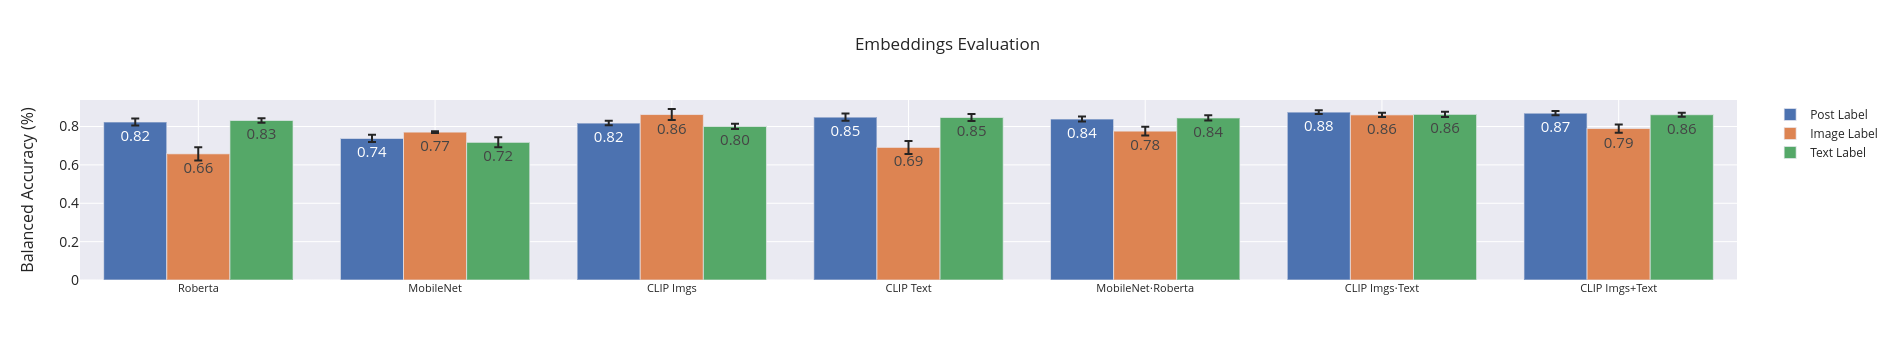

In [80]:
import plotly.graph_objects as go
data = resuls_dataframe.copy()
data = data.set_index('Embedding')
data = data.rename({'Roberta_embeddings':'Roberta',
                                        'MobileNet_embeddings':'MobileNet',
                                        'MobileNet_Roberta_embeddings':'MobileNet⋅Roberta',
                                        'clip_imgs_embeddings' : 'CLIP Imgs',
                                        'clip_text_embeddings': 'CLIP Text',
                                        'clip_imgs_cat_text_embeddings': 'CLIP Imgs⋅Text',
                                        'clip_imgs_sum_text_embeddings': 'CLIP Imgs+Text'
                                       },axis='index')


fig = go.Figure()
fig.add_trace(go.Bar(
    name='Post Label',
    x=data.index, y=data['Post_ACC_test'],
    error_y=dict(type='data', array=data['Post_ACC_test_std'],
                ),
   
))
fig.add_trace(go.Bar(
    name='Image Label',
    x=data.index,  y=data['Img_ACC_test'],
    error_y=dict(type='data', array=data['Img_ACC_test_std']),
))
fig.add_trace(go.Bar(
    name='Text Label',
    x=data.index, y=data['Txt_ACC_test'],
    error_y=dict(type='data', array=data['Txt_ACC_test_std']),
))
fig.update_traces(texttemplate='%{y:.2f}', textposition='auto',textfont_size=15)
fig.update_layout(barmode='group',
                 
                title='Embeddings Evaluation',
                xaxis_tickfont_size=11,
                yaxis=dict(
                title='Balanced Accuracy (%)',
                titlefont_size=16,
                tickfont_size=14,
                ),
                template='seaborn'
                 
                 )
fig.write_image("embeddings_experiment.pdf", width= 1500,height=300, scale=10)
fig.show()